In [1]:
import os, time
import matplotlib.pyplot as plt
import numpy as np
import dgl
import dgl.nn.functional as fn
import pickle as pkl
import torch
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [3]:
import seaborn
import matplotlib.ticker as ticker

In [4]:
import torch.nn.functional as F

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [6]:
from utils import *
from xgnn_src.node.eval import *

In [7]:
Arg = collections.namedtuple("Arg", ["teacher_name", "hidden_sizes", "n_layers", "dropout", "n_hidden", "n_heads", "n_out_heads", "negative_slope", "residual", "all_layer_dp", "skip_norm"])

```
python train.py --teacher-name gat --dataset BAS --n-epochs 1000 --n-hidden 32 
--n-layers 3 --n-heads 1 --lr 0.01 --all-layer-dp --skip-norm --self-loop --gpu 0 --teacher-pretrain ./ckpt/gat/ba_shape01.pt
```

### Using directed graph (default)

In [8]:
# ba_shape1.g, ba_shape.pt
with open('./datasets/ba_shape_bidir.g', 'rb') as f:
    g = pkl.load(f)
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)
num_classes = 4
test_labels = g.ndata['label'][g.ndata['test_mask']]
feats = g.ndata['feat'].size()[1]
arg = Arg("gat", [64], 3, 0.5, 16, 3, 1, 0.2, False, True, True)
model = init_teacher(arg, g, feats, num_classes)
ckpt = torch.load('./ckpt/gat/ba_shap_bidir01.pt', map_location="cuda:0")
model.load_state_dict(ckpt)

GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=3, out_features=48, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=48, out_features=48, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=48, out_features=48, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=48, out_features=4, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)


<All keys matched successfully>

In [9]:
compute_edge_weights(model, g, 'gat')

In [10]:
selected = list(range(400, 700, 5))

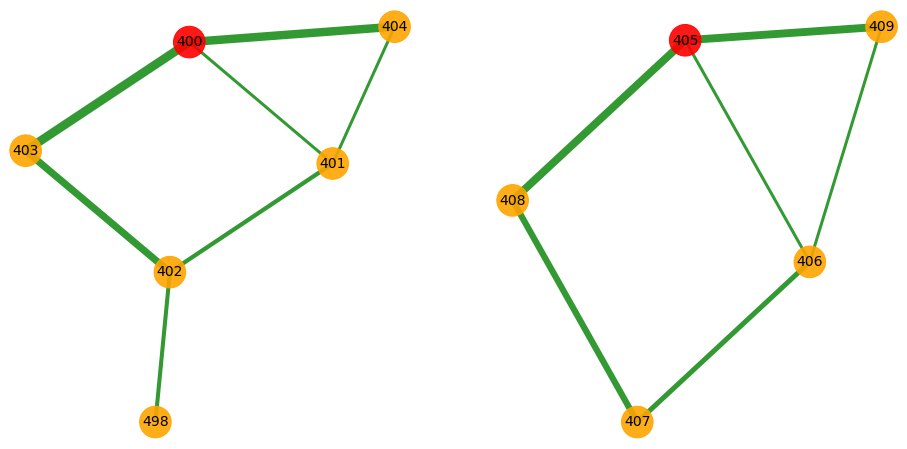

In [11]:
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
explain_test(g, 400, 6, ax=ax[0], undir=True, scale=30)
ax[0].set_axis_off()
# 103, 276, 289
explain_test(g, 405, 5, ax=ax[1], undir=True, scale=30)
ax[1].set_axis_off()
# plt.savefig('./images/ba_shape.svg', format="svg", dpi=300)

When a node connect to a high degree node => affected by this node when performing PPR

In [11]:
selected_node = list(range(400, 700, 5))
test_graphs = [extract_true_motif(g, i, 399, 5, True) for i in selected_node]

In [16]:
s = time.time()
pred, rec, _ = evaluate_dataset(g, selected_node, test_graphs, 5, 7, ignore_self_loop=True, dumping_factor=0.55)
print("Precision: %.4f Recall %.4f F1 %.4f"  % (pred, rec, pred*rec*2/(pred+rec)))
print(time.time() - s)

60it [00:01, 37.07it/s]

Precision: 0.9863 Recall 1.0000 F1 0.9931
1.625706434249878


In [23]:
s = time.time()
graphs = khop_batch(model, g, selected_node, 2, model_name='gat')
eval_dataset2(test_graphs, graphs)
print(time.time() - s)

F1 Score: 0.939394
P Score: 0.893484
R score: 0.990278
0.15517950057983398


## BA Community

In [24]:
with open('./datasets/ba_community_bidir.g', 'rb') as f:
    g1 = pkl.load(f)

num_classes = 8
g1 = dgl.remove_self_loop(g1)
g1 = dgl.add_self_loop(g1)
test_labels1 = g1.ndata['label'][g1.ndata['test_mask']]
feats1 = g1.ndata['feat'].size()[1]
arg1 = Arg("gat", [64], 3, 0.5, 32, 3, 1, 0.2, False, True, True)
model1 = init_teacher(arg1, g1, feats1, num_classes)
ckpt1 = torch.load('./ckpt/gat/ba_community_bidir01.pt', map_location="cuda:0")
model1.load_state_dict(ckpt1)

GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=12, out_features=96, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=96, out_features=96, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=96, out_features=96, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=96, out_features=8, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)


<All keys matched successfully>

In [25]:
compute_edge_weights(model1, g1, 'gat')

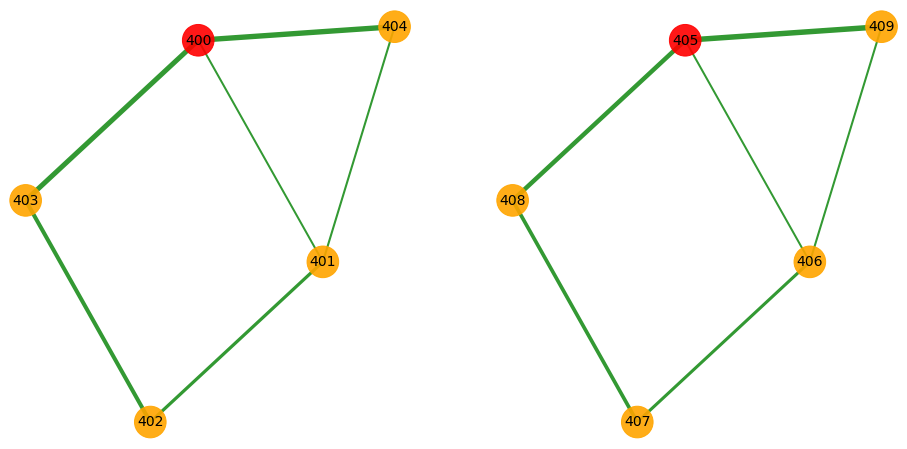

In [55]:
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
explain_test(g1, 400, 10, ax=ax[0], scale=20)
ax[0].set_axis_off()
explain_test(g1, 405, 10, ax=ax[1], scale=20)
ax[1].set_axis_off()
# plt.savefig('./images/ba_community.svg', format="svg", dpi=300)

In [26]:
test_graphs2 = [extract_true_motif(g1, i, 399, 5, True) for i in selected_node]

In [27]:
s = time.time()
pred1, rec1, _ = evaluate_dataset(g1, selected_node, test_graphs2, 5, 7, ignore_self_loop=True, dumping_factor=0.55)
print(time.time() - s)

60it [00:02, 25.95it/s]

2.3200454711914062


In [28]:
print("F1: %.4f Precision: %.4f Recall %.4f"  % (pred1*rec1*2/(pred1+rec1), pred1, rec1))

F1: 0.9315 Precision: 0.9189 Recall 0.9444


In [31]:
s = time.time()
graphs2 = khop_batch(model1, g1, selected_node, 2, model_name='gat')
eval_dataset2(test_graphs2, graphs2)
print(time.time() - s)

F1 Score: 0.829095
P Score: 0.721936
R score: 0.973611
0.19450998306274414
